# Load data

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [49]:
import scanpy as sc

#combined_adata = ad.read_h5ad('/storage/users/data/PANC/combined_adata.h5ad')
#adata = sc.read("/storage/users/data/PANC/filtered_preprocessed_combined_adata.h5ad")
#adata = sc.read("/storage/users/data/PANC/annotated_adata.h5ad")
adata = sc.read("/storage/users/data/PANC/clustered_adata.h5ad")
#adata = sc.read("/storage/users/data/PANC/cellcycle_adata.h5ad")

In [50]:
adata

AnnData object with n_obs × n_vars = 10594 × 2000
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_combined', 'louvain', 'louvain_combined'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_combined_colors', 'log1p', 'louvain', 'louvain_combined_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Test Data distributions

In [51]:
# Step 1: Generate or input your data (replace with your data)
data = np.random.lognormal(mean=0, sigma=1, size=1000)
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(1000,)


In [52]:
first_column = adata.X[:, 0]
data = first_column.toarray()
print(type(data))
print(data.shape)
data = data[np.isfinite(data)]

<class 'numpy.ndarray'>
(10594, 1)


In [53]:
if len(data.shape) > 1 and data.shape[1] == 1:  # if it's a column vector
    data = data.ravel()

In [54]:
print(data.shape)

(10594,)


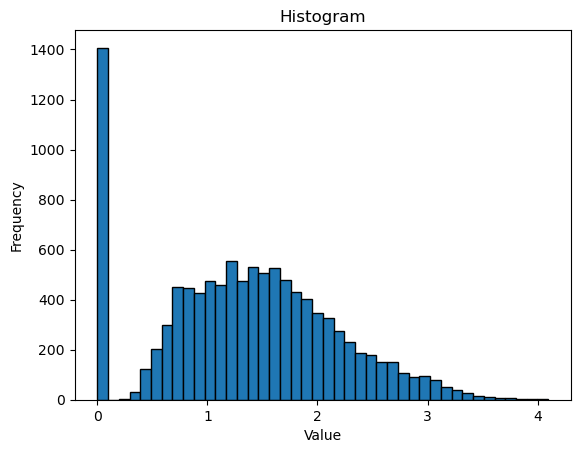

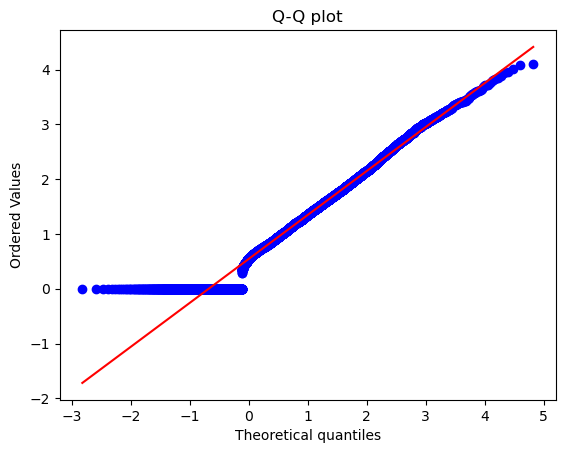

K-S statistic: 0.1811608676107626
P-value: 1.035646857406889e-304
Reject the null hypothesis, the data does not follow a lognormal distribution.


In [55]:
# Step 2: Visual Inspection using a histogram
plt.hist(data, bins='auto', edgecolor='black')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Step 3: Q-Q plot
stats.probplot(data, dist='norm', sparams=(1,), plot=plt)
plt.title('Q-Q plot')
plt.show()

# Step 4: Statistical test (Kolmogorov-Smirnov test)
# Here, we use the lognormal distribution as the comparison distribution
D, p_value = stats.kstest(data, 'norm', args=(1,))
print(f'K-S statistic: {D}')
print(f'P-value: {p_value}')

# Interpretation
if p_value > 0.05:
    print('Fail to reject the null hypothesis, the data follows a lognormal distribution.')
else:
    print('Reject the null hypothesis, the data does not follow a lognormal distribution.')

In [56]:
import powerlaw

# Fit the data to a power-law distribution
fit = powerlaw.Fit(data)

# Print out the alpha parameter (scaling exponent) of the power-law fit
print(fit.power_law.alpha)

# Compare the power-law fit to an exponential fit, for instance
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

print(R, p)

ModuleNotFoundError: No module named 'powerlaw'

In [57]:
print(adata.obs['condition'])

barcode
AAACCCAGTAGGCTCC-1         CTRL_1
AAACCCAGTCGCAACC-1         CTRL_1
AAACCCATCCACAAGT-1         CTRL_1
AAACGCTTCACTACGA-1         CTRL_1
AAACGCTTCAGCCTCT-1         CTRL_1
                         ...     
TTTACTGTCATTACTC-1    TGFb1_GEM_2
TTTCACAGTGATATAG-1    TGFb1_GEM_2
TTTCACATCGATGCAT-1    TGFb1_GEM_2
TTTCATGTCCCTCTAG-1    TGFb1_GEM_2
TTTGACTGTTCCGGTG-1    TGFb1_GEM_2
Name: condition, Length: 10594, dtype: category
Categories (8, object): ['CTRL_1', 'CTRL_2', 'CTRL_2D', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']


In [58]:
adata.obs['condition'].cat.categories


Index(['CTRL_1', 'CTRL_2', 'CTRL_2D', 'GEM_2', 'TGFb1_1', 'TGFb1_2',
       'TGFb1_GEM_1', 'TGFb1_GEM_2'],
      dtype='object')

# Differential expression analysis 


## Get and show all conditions

In [73]:
# Specify the groups you want to compare
categories_list = list(adata.obs['condition'].cat.categories)
print(categories_list)

#conditions = ['CTRL_1', 'CTRL_2', 'CTRL_2D', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']
conditions = categories_list


['CTRL_1', 'CTRL_2', 'CTRL_2D', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']


## Get and show the leiden clusters

In [74]:
print(adata.obs['leiden'])


barcode
AAACCCAGTAGGCTCC-1     1
AAACCCAGTCGCAACC-1    11
AAACCCATCCACAAGT-1     5
AAACGCTTCACTACGA-1     8
AAACGCTTCAGCCTCT-1     6
                      ..
TTTACTGTCATTACTC-1    14
TTTCACAGTGATATAG-1     3
TTTCACATCGATGCAT-1     3
TTTCATGTCCCTCTAG-1     7
TTTGACTGTTCCGGTG-1     3
Name: leiden, Length: 10594, dtype: category
Categories (18, object): ['0', '1', '2', '3', ..., '14', '15', '16', '17']


In [61]:
unique_values = np.unique([int(x) for x in adata.obs['leiden'].values])
print(unique_values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [62]:
#leidens = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' 10', '13', '14', '15', '16']
leidens = unique_values

# Differential Analysis

## get information of your single cell object

In [66]:
print(adata)

AnnData object with n_obs × n_vars = 10594 × 2000
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_combined', 'louvain', 'louvain_combined'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_combined_colors', 'log1p', 'louvain', 'louvain_combined_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


### get information about how the counts are store
### log transformed?
### sometimes the base of the logtransformation is not stored properly. this information can be added afterwards. 

In [75]:
if 'log1p' in adata.uns and 'base' not in adata.uns['log1p']:
    adata.uns['log1p']['base'] = np.e  # Assuming natural logarithm was used. Change accordingly if it was a different base.

## Comparison of all vs. all

In [181]:
comparisons = []
for i in range(len(conditions)):
    for j in range(i+1, len(conditions)):
        comparisons.append((conditions[i], conditions[j]))

In [182]:
comparisons

[('CTRL_1', 'CTRL_2'),
 ('CTRL_1', 'CTRL_2D'),
 ('CTRL_1', 'GEM_2'),
 ('CTRL_1', 'TGFb1_1'),
 ('CTRL_1', 'TGFb1_2'),
 ('CTRL_1', 'TGFb1_GEM_1'),
 ('CTRL_1', 'TGFb1_GEM_2'),
 ('CTRL_2', 'CTRL_2D'),
 ('CTRL_2', 'GEM_2'),
 ('CTRL_2', 'TGFb1_1'),
 ('CTRL_2', 'TGFb1_2'),
 ('CTRL_2', 'TGFb1_GEM_1'),
 ('CTRL_2', 'TGFb1_GEM_2'),
 ('CTRL_2D', 'GEM_2'),
 ('CTRL_2D', 'TGFb1_1'),
 ('CTRL_2D', 'TGFb1_2'),
 ('CTRL_2D', 'TGFb1_GEM_1'),
 ('CTRL_2D', 'TGFb1_GEM_2'),
 ('GEM_2', 'TGFb1_1'),
 ('GEM_2', 'TGFb1_2'),
 ('GEM_2', 'TGFb1_GEM_1'),
 ('GEM_2', 'TGFb1_GEM_2'),
 ('TGFb1_1', 'TGFb1_2'),
 ('TGFb1_1', 'TGFb1_GEM_1'),
 ('TGFb1_1', 'TGFb1_GEM_2'),
 ('TGFb1_2', 'TGFb1_GEM_1'),
 ('TGFb1_2', 'TGFb1_GEM_2'),
 ('TGFb1_GEM_1', 'TGFb1_GEM_2')]

In [183]:
import scanpy as sc
import pandas as pd

# Example list of group comparisons
#comparisons = [('group1', 'group2'), ('group3', 'group4')]  # Replace with your actual group names

# Assuming 'adata' is your AnnData object already loaded with your data
# Example: adata = sc.read_h5ad('your_data_file.h5ad')

# Ensure the 'condition' column is categorical
adata.obs['condition'] = adata.obs['condition'].astype('category')

# Initialize an empty DataFrame to store results
results_df_aVSa = pd.DataFrame()

for group1, group2 in comparisons:
    # Subset the data for only the two groups you're comparing and make an explicit copy
    subset = adata[adata.obs['condition'].isin([group1, group2])].copy()
    
    # Mark these two conditions in the subset
    subset.obs['group_comparison'] = subset.obs['condition'].astype(str)
    
    # Ensure the 'group_comparison' column is categorical
    subset.obs['group_comparison'] = subset.obs['group_comparison'].astype('category')
    
    # Differential expression analysis
    sc.tl.rank_genes_groups(subset, 'group_comparison', method='wilcoxon')
    
    # Convert result to dataframe
    result = pd.DataFrame({
        'ID': adata.uns['rank_genes_groups']['names']['target'],
        'log2FC': adata.uns['rank_genes_groups']['logfoldchanges']['target'],
        'p.value': adata.uns['rank_genes_groups']['pvals']['target'],
        'adjusted.p.value': adata.uns['rank_genes_groups']['pvals_adj']['target']
    })

    # Calculate basemean expression for genes present in adata.var_names
    result['basemean'] = [
        (adata[:, gene].X.sum() / adata.shape[0]) if gene in adata.var_names else 'NA' 
        for gene in result['ID']
    ]

    # Convert ensembl IDs to gene symbols
    result['symbol'] = result['ID'].map(ensembl_to_gene_name).fillna(result['ID'])

    # Assign comparison name
    result['comparison'] = group1 + group2

    # Append result to the main dataframe
    results_df_aVSa = pd.concat([results_df_aVSa, result])


In [184]:
results_df_aVSa

,ID,log2FC,p.value,adjusted.p.value,basemean,symbol,comparison
0,ENSG00000124225,2.483969,2.563447e-121,5.126895e-118,1.361542,PMEPA1,CTRL_1CTRL_2
1,ENSG00000106366,2.678602,5.103405e-115,5.103405e-112,2.611266,SERPINE1,CTRL_1CTRL_2
2,ENSG00000011028,1.917421,2.633708e-98,1.316854e-95,0.896310,MRC2,CTRL_1CTRL_2
3,ENSG00000152952,1.805905,1.750571e-97,7.002286e-95,1.244271,PLOD2,CTRL_1CTRL_2
4,ENSG00000108821,2.994153,1.119842e-95,3.732807e-93,0.763426,COL1A1,CTRL_1CTRL_2
...,...,...,...,...,...,...,...
1995,ENSG00000087086,-0.913274,3.445712e-68,2.650547e-66,3.922895,FTL,TGFb1_GEM_1TGFb1_GEM_2
1996,ENSG00000170421,-1.676459,9.608099e-69,8.354869e-67,1.371500,KRT8,TGFb1_GEM_1TGFb1_GEM_2
1997,ENSG00000152056,-2.923657,1.761326e-70,1.761326e-68,0.767639,AP1S3,TGFb1_GEM_1TGFb1_GEM_2
1998,ENSG00000107984,-3.204330,2.781010e-73,2.927379e-71,0.932679,DKK1,TGFb1_GEM_1TGFb1_GEM_2


In [186]:
# Reorder columns
results_df_aVSa = results_df_aVSa[['comparison', 'ID', 'symbol', 'basemean', 'log2FC', 'p.value', 'adjusted.p.value']]
# write to file location
results_df_aVSa.to_csv("/storage/users/data/PANC/diff_anaylsis_conditions_results_df_aVSa.csv", index=False)

## Comparison certain contion vs. all other conditions

In [168]:
import scanpy as sc
import pandas as pd

# Initialize an empty dataframe to store results
results_df = pd.DataFrame()

# Example conditions
# conditions = ['CTRL_1', 'CTRL_2', 'CTRL_2D', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']

# Initialize an empty DataFrame to store results
results_df_1VSa = pd.DataFrame()

for condition in conditions:
    # Create a new column for grouping: the condition vs. all others
    adata.obs['grouping'] = ['target' if x == condition else 'others' for x in adata.obs['condition']]
    
    # Perform differential expression
    sc.tl.rank_genes_groups(adata, 'grouping', method='wilcoxon', n_genes=adata.shape[1])
    
    # Convert result to dataframe
    result = pd.DataFrame({
        'ID': adata.uns['rank_genes_groups']['names']['target'],
        'log2FC': adata.uns['rank_genes_groups']['logfoldchanges']['target'],
        'p.value': adata.uns['rank_genes_groups']['pvals']['target'],
        'adjusted.p.value': adata.uns['rank_genes_groups']['pvals_adj']['target']
    })

    # Calculate basemean expression for genes present in adata.var_names
    result['basemean'] = [
        (adata[:, gene].X.sum() / adata.shape[0]) if gene in adata.var_names else 'NA' 
        for gene in result['ID']
    ]

    # Convert ensembl IDs to gene symbols
    result['symbol'] = result['ID'].map(ensembl_to_gene_name).fillna(result['ID'])

    # Assign comparison name
    result['comparison'] = condition + "_vs_others"

    # Append result to the main dataframe
    results_df_1VSa = pd.concat([results_df_1VSa, result])

In [171]:
print(results_df_1VSa)

                   ID    log2FC       p.value  adjusted.p.value  basemean  \
0     ENSG00000176171  1.748443  0.000000e+00      0.000000e+00  2.080871   
1     ENSG00000170345  2.931980  0.000000e+00      0.000000e+00  0.855127   
2     ENSG00000234741  1.802805  0.000000e+00      0.000000e+00  2.287247   
3     ENSG00000196352  2.583366  0.000000e+00      0.000000e+00  0.886835   
4     ENSG00000177410  1.210990  0.000000e+00      0.000000e+00  2.994796   
...               ...       ...           ...               ...       ...   
1995  ENSG00000087086 -0.913274  3.445712e-68      2.650547e-66  3.922895   
1996  ENSG00000170421 -1.676459  9.608099e-69      8.354869e-67  1.371500   
1997  ENSG00000152056 -2.923657  1.761326e-70      1.761326e-68  0.767639   
1998  ENSG00000107984 -3.204330  2.781010e-73      2.927379e-71  0.932679   
1999  ENSG00000111057 -2.303637  1.449464e-98      9.663090e-96  1.790049   

     symbol             comparison  
0     BNIP3       CTRL_1_vs_others  
1

In [173]:
# Reorder columns
results_df_1VSa = results_df_1VSa[['comparison', 'ID', 'symbol', 'basemean', 'log2FC', 'p.value', 'adjusted.p.value']]

In [174]:
# write to file location
results_df_1VSa.to_csv("/storage/users/data/PANC/diff_anaylsis_conditions_results_df_1VSa.csv", index=False)

### Test if all Ensemble Gene IDs have a valid gene symbol

In [175]:
import pandas as pd

# Create unique mappings of ID and symbol
unique_mappings = results_df_1VSa[['ID', 'symbol']].drop_duplicates()

# Filter out IDs with valid symbols
mapped_ids_df = unique_mappings[unique_mappings['symbol'].notnull() & (unique_mappings['symbol'] != '')]

# Count the number of IDs with valid symbols
num_mapped_ids = mapped_ids_df.shape[0]

# Count the total number of unique IDs
total_ids = unique_mappings.shape[0]

# Calculate the percentage of IDs with valid symbols
percentage_mapped = (num_mapped_ids / total_ids) * 100

print(f"Number of unique IDs with valid symbols: {num_mapped_ids}")
print(f"Total number of unique IDs: {total_ids}")
print(f"Percentage of unique IDs with valid symbols: {percentage_mapped:.2f}%")

# Show unique mappings of ID and symbol
print("\nUnique mappings of ID and symbol:")
print(unique_mappings)

# Show examples where ID has no matching symbol
no_symbol_df = unique_mappings[unique_mappings['symbol'].isnull() | (unique_mappings['symbol'] == '')]
print("\nExamples where ID has no matching symbol:")
print(no_symbol_df)



Number of unique IDs with valid symbols: 1626
Total number of unique IDs: 2000
Percentage of unique IDs with valid symbols: 81.30%

Unique mappings of ID and symbol:
                   ID symbol
0     ENSG00000176171  BNIP3
1     ENSG00000170345    FOS
2     ENSG00000234741   GAS5
3     ENSG00000196352   CD55
4     ENSG00000177410  ZFAS1
...               ...    ...
1995  ENSG00000124766   SOX4
1996  ENSG00000145555  MYO10
1997  ENSG00000140416   TPM1
1998  ENSG00000149948  HMGA2
1999  ENSG00000164032  H2AZ1

[2000 rows x 2 columns]

Examples where ID has no matching symbol:
                   ID symbol
17    ENSG00000258757       
95    ENSG00000273132       
125   ENSG00000274213       
145   ENSG00000249679       
167   ENSG00000276533       
...               ...    ...
1487  ENSG00000266877       
1537  ENSG00000233635       
1597  ENSG00000258077       
1622  ENSG00000287001       
1758  ENSG00000250697       

[374 rows x 2 columns]


# Visualize the results

In [200]:
import pandas as pd
results_df = pd.read_csv("/storage/users/data/PANC/diff_anaylsis_conditions_results_df_1VSa.csv")

In [201]:
adata

AnnData object with n_obs × n_vars = 10594 × 2000
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_combined', 'louvain', 'louvain_combined', 'grouping'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_combined_colors', 'log1p', 'louvain', 'louvain_combined_colors', 'neighbors', 'pca', 'umap', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [202]:
sorted_unique_comparisons = sorted(results_df['comparison'].unique())
print(sorted_unique_comparisons)

['CTRL_1_vs_others', 'CTRL_2D_vs_others', 'CTRL_2_vs_others', 'GEM_2_vs_others', 'TGFb1_1_vs_others', 'TGFb1_2_vs_others', 'TGFb1_GEM_1_vs_others', 'TGFb1_GEM_2_vs_others']


## Visualize Top Genes for the comparions conditions vs all other V1

In [203]:
results_df

,comparison,ID,symbol,basemean,log2FC,p.value,adjusted.p.value
0,CTRL_1_vs_others,ENSG00000176171,BNIP3,2.080871,1.748442,0.000000e+00,0.000000e+00
1,CTRL_1_vs_others,ENSG00000170345,FOS,0.855127,2.931980,0.000000e+00,0.000000e+00
2,CTRL_1_vs_others,ENSG00000234741,GAS5,2.287247,1.802805,0.000000e+00,0.000000e+00
3,CTRL_1_vs_others,ENSG00000196352,CD55,0.886835,2.583366,0.000000e+00,0.000000e+00
4,CTRL_1_vs_others,ENSG00000177410,ZFAS1,2.994796,1.210990,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...
15995,TGFb1_GEM_2_vs_others,ENSG00000087086,FTL,3.922895,-0.913273,3.445712e-68,2.650547e-66
15996,TGFb1_GEM_2_vs_others,ENSG00000170421,KRT8,1.371500,-1.676459,9.608099e-69,8.354869e-67
15997,TGFb1_GEM_2_vs_others,ENSG00000152056,AP1S3,0.767639,-2.923657,1.761326e-70,1.761326e-68
15998,TGFb1_GEM_2_vs_others,ENSG00000107984,DKK1,0.932679,-3.204330,2.781010e-73,2.927379e-71


['CTRL_1_vs_others', 'CTRL_2D_vs_others', 'CTRL_2_vs_others', 'GEM_2_vs_others', 'TGFb1_1_vs_others', 'TGFb1_2_vs_others', 'TGFb1_GEM_1_vs_others', 'TGFb1_GEM_2_vs_others']


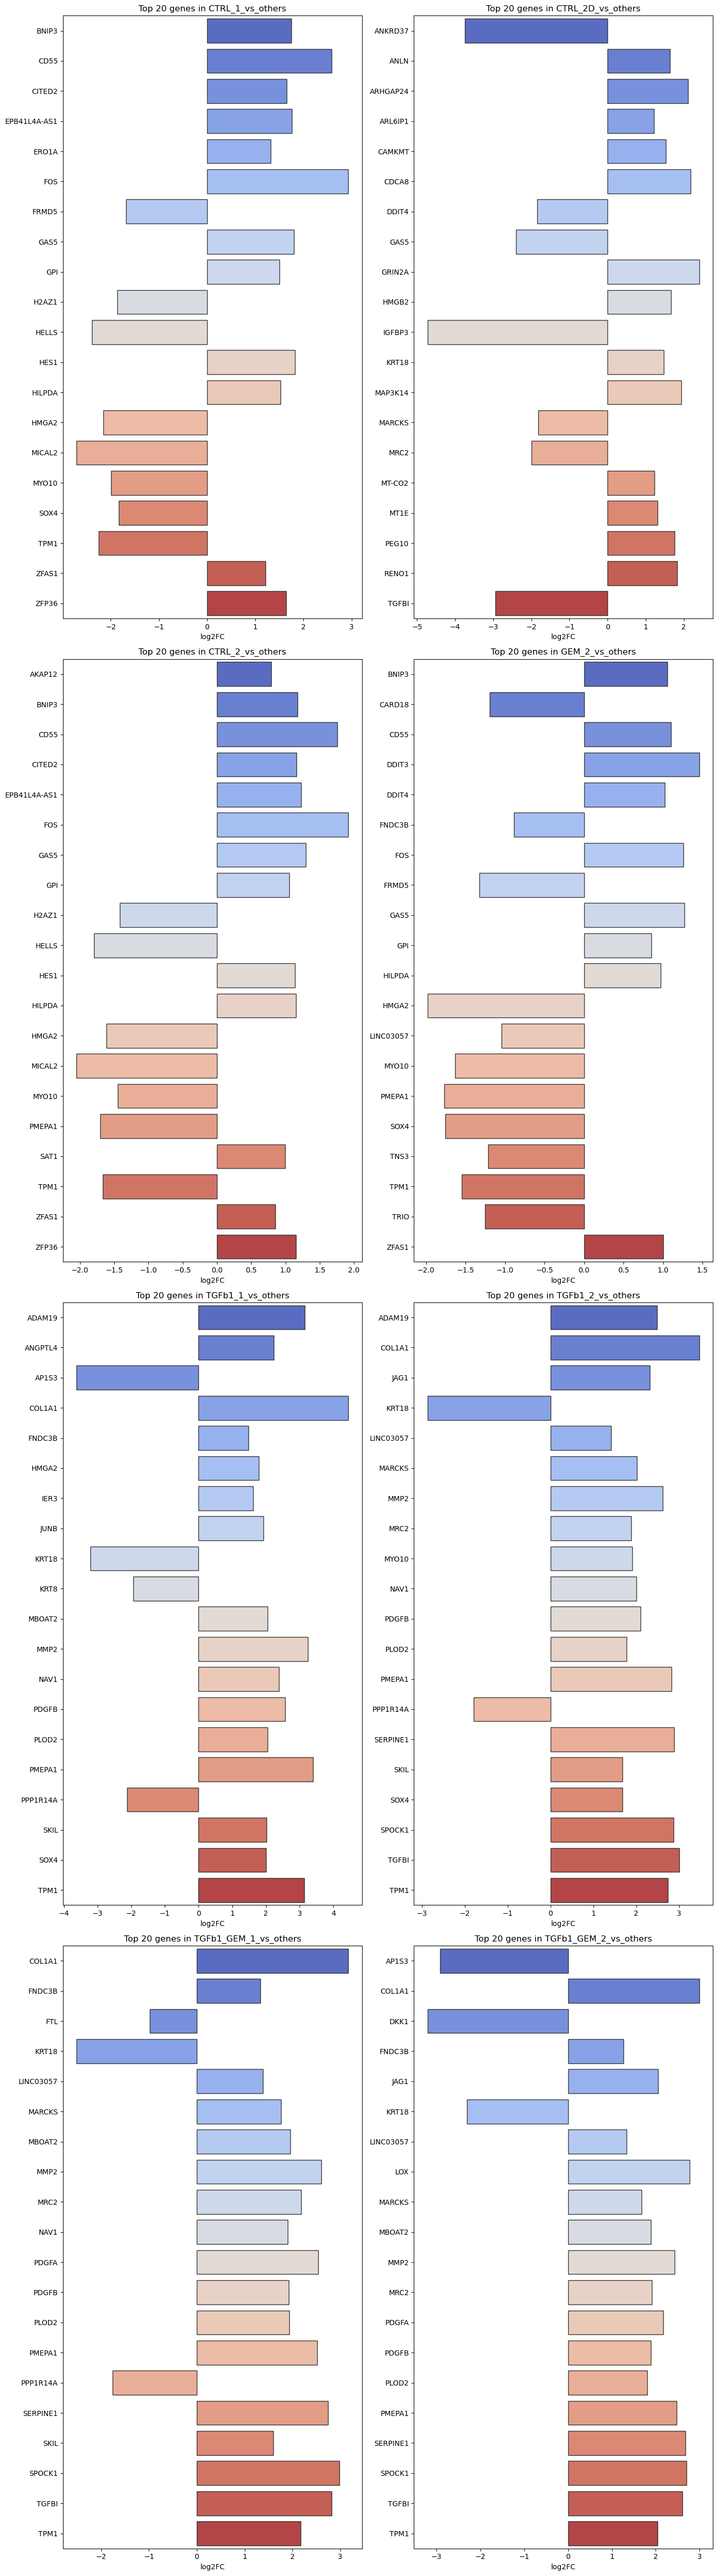

In [204]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you've already loaded your dataframe as results_df
sorted_unique_comparisons = sorted(results_df['comparison'].unique())
print(sorted_unique_comparisons)

# Calculate the number of unique comparisons
unique_comparisons = results_df['comparison'].unique()
num_unique_comparisons = len(unique_comparisons)

# Determine the number of rows and columns for the subplots
nrowss = (num_unique_comparisons + 1) // 2

# Initialize the 4x2 subplot grid
fig, axes = plt.subplots(nrows=nrowss, ncols=2, figsize=(14, 50))
fig.subplots_adjust(hspace=0.5)  # Adjust space between plots

for index, comparison in enumerate(sorted_unique_comparisons):

    # Extract results for a specific comparison
    specific_comparison = comparison  # example
    filtered_results = results_df[results_df['comparison'] == specific_comparison]
    
    # Visualize the top genes
    # Sort by adjusted p-value and pick tops n genes
    n_top_genes = 20  # for instance
    #top_genes = filtered_results.sort_values(by="adjusted.p.value", ascending=True).head(n_top_genes)
    #print(top_genes)
    # Get top 20 genes by adjusted.p.value
    top_by_pvalue = filtered_results.sort_values(by="adjusted.p.value", ascending=True).head(n_top_genes)
    
    # Now, sort those top 20 genes by symbol
    top_genes = top_by_pvalue.sort_values(by="symbol", ascending=True)

    
    
    # Generate a bar plot in the appropriate subplot
    ax = axes[index // 2, index % 2]  # Determine the row and column for subplot
    sns.barplot(data=top_genes, x="log2FC", y="symbol", palette="coolwarm", edgecolor=".2", ax=ax)
    ax.set_title(f"Top {n_top_genes} genes in {comparison}")
    ax.set_xlabel('log2FC')  # Set x-axis label
    ax.set_ylabel('')  # Clear y-axis label for brevity

plt.tight_layout()
plt.show()

## Visualize Top Genes for the comparions conditions vs all other V2

['CTRL_1_vs_others', 'CTRL_2D_vs_others', 'CTRL_2_vs_others', 'GEM_2_vs_others', 'TGFb1_1_vs_others', 'TGFb1_2_vs_others', 'TGFb1_GEM_1_vs_others', 'TGFb1_GEM_2_vs_others']


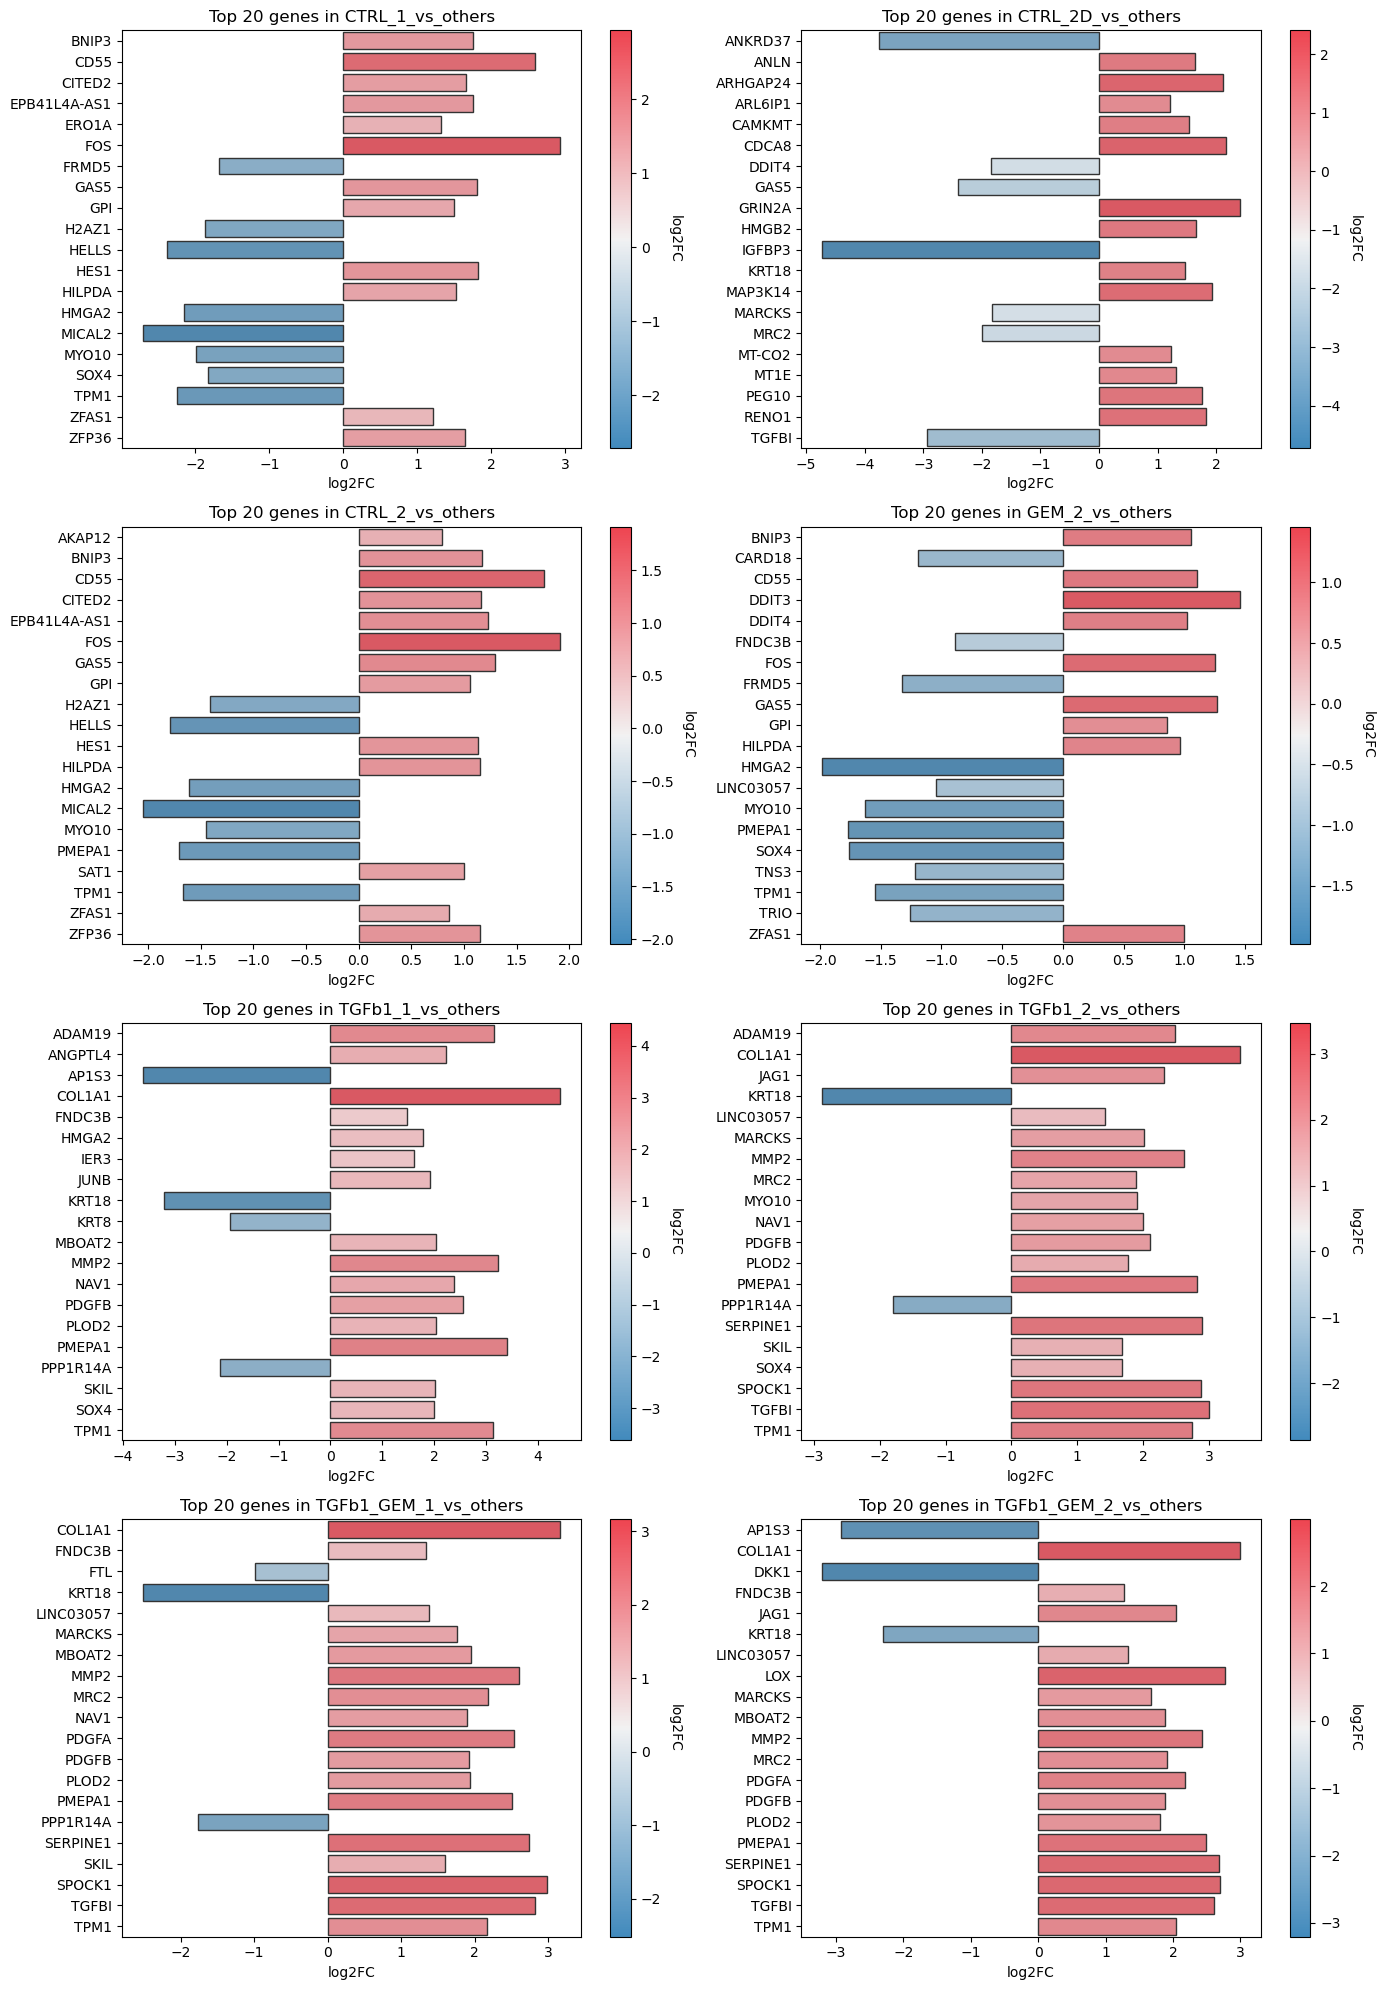

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you've already loaded your dataframe as results_df
sorted_unique_comparisons = sorted(results_df['comparison'].unique())
print(sorted_unique_comparisons)

# Initialize the 4x2 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 20))
fig.subplots_adjust(hspace=0.5)  # Adjust space between plots

for index, comparison in enumerate(sorted_unique_comparisons):

    # Extract results for a specific comparison
    specific_comparison = comparison  # example
    filtered_results = results_df[results_df['comparison'] == specific_comparison]
    
    # Get top 20 genes by adjusted.p.value
    n_top_genes = 20  # for instance
    top_by_pvalue = filtered_results.sort_values(by="adjusted.p.value", ascending=True).head(n_top_genes)
    
    # Now, sort those top 20 genes by symbol
    top_genes = top_by_pvalue.sort_values(by="symbol", ascending=True)

    # Generate a color mapping for log2FC
    cmap = sns.diverging_palette(240, 10, s=80, l=55, as_cmap=True)  # Blue to white to red
    norm_log2FC = plt.Normalize(top_genes["log2FC"].min(), top_genes["log2FC"].max())
    log2FC_colors = cmap(norm_log2FC(top_genes["log2FC"].values))
    
    # Generate a bar plot in the appropriate subplot
    ax = axes[index // 2, index % 2]  # Determine the row and column for subplot
    sns.barplot(data=top_genes, x="log2FC", y="symbol", palette=log2FC_colors, edgecolor=".2", ax=ax)
    ax.set_title(f"Top {n_top_genes} genes in {comparison}")
    ax.set_xlabel('log2FC')  # Set x-axis label
    ax.set_ylabel('')  # Clear y-axis label for brevity
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_log2FC)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("log2FC", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [144]:
import os
# Save the figure
fig.savefig('figures/comparisons_plot.png', bbox_inches='tight')

## Volcanos

In [ ]:
#!pip install adjustText

/home2/lumpi/miniconda3/envs/scanpy-env3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


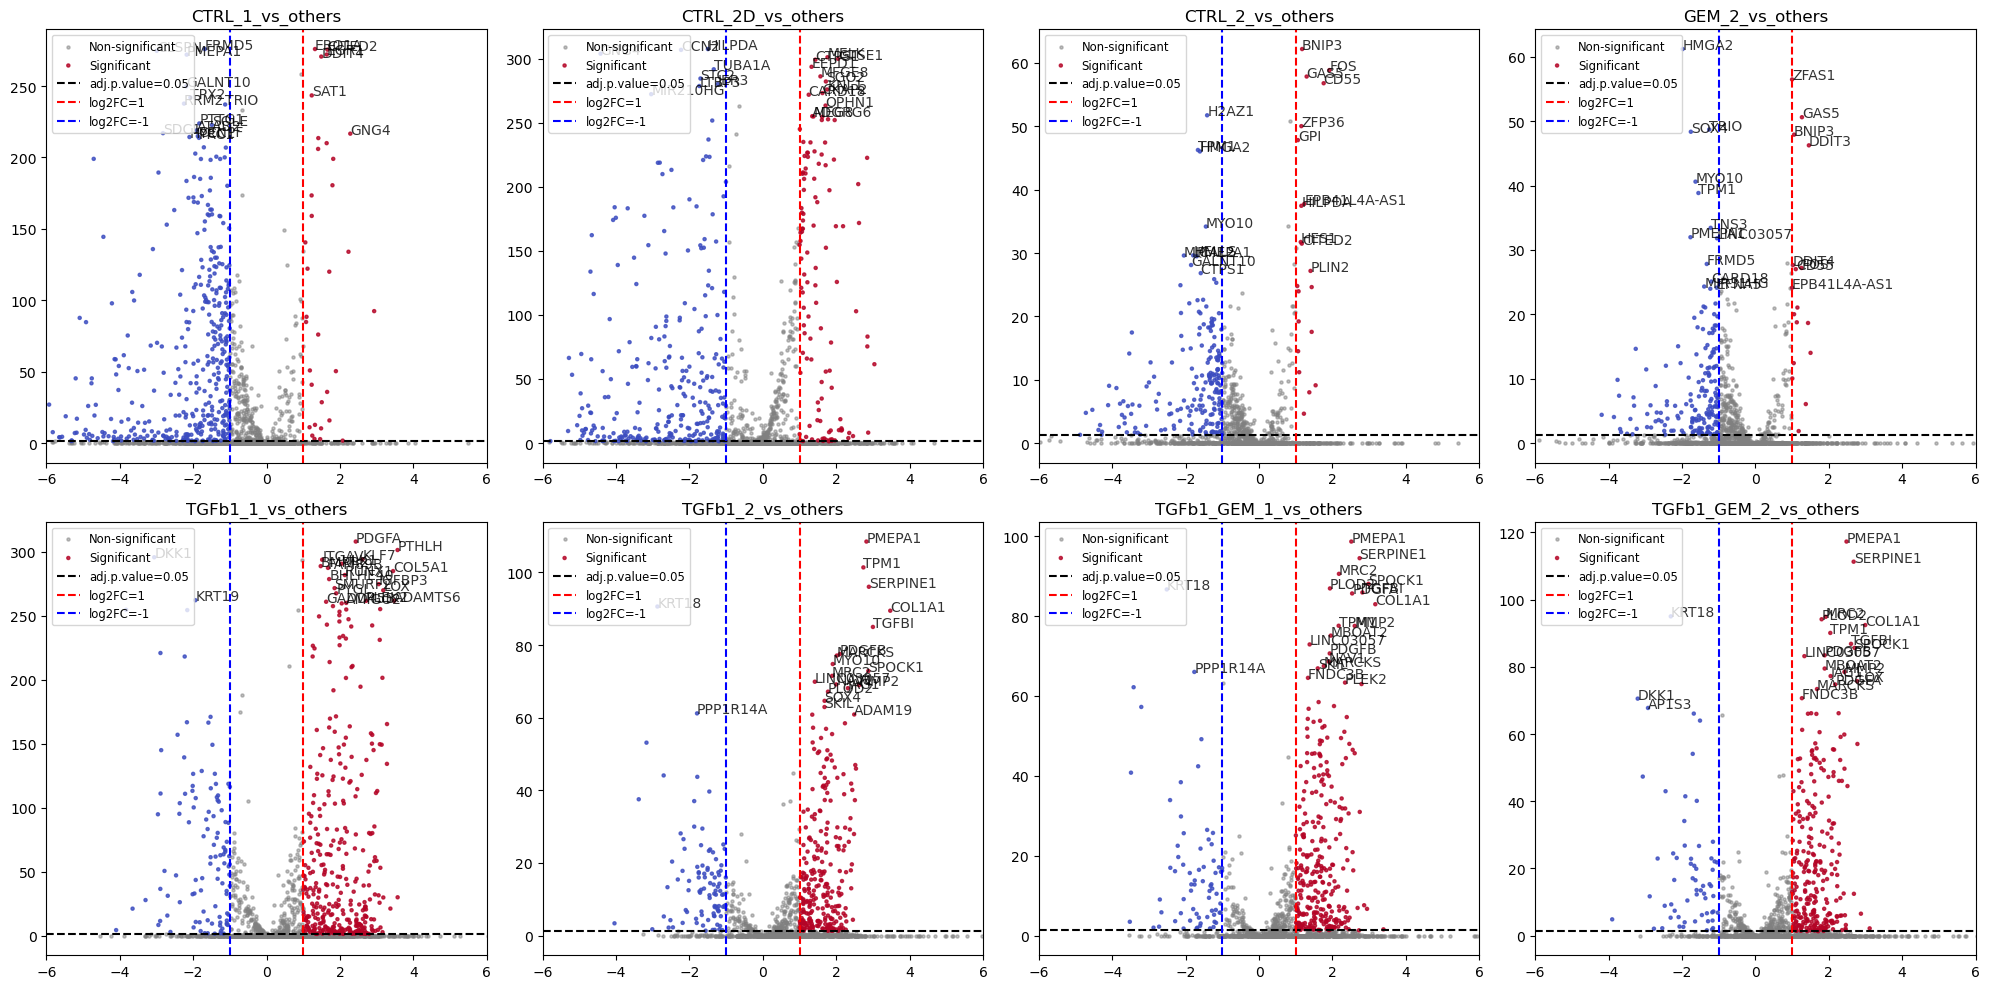

In [130]:
#... [previous part of the code]

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

log2fc_threshold = 1
adj_pval_threshold = 0.05

for idx, comparison in enumerate(sorted_unique_comparisons):
    ax = axs[idx // 4, idx % 4]

    filtered_results = results_df[results_df['comparison'] == comparison]

    # Define a mask for significant genes
    significant_mask = (filtered_results['log2FC'].abs() > log2fc_threshold) & (filtered_results['log2FC'] != 0) & (filtered_results['adjusted.p.value'] < adj_pval_threshold) & (filtered_results['adjusted.p.value'] != 0)

    # Scatter points: Non-significant
    ax.scatter(filtered_results.loc[~significant_mask, 'log2FC'], -np.log10(filtered_results.loc[~significant_mask, 'adjusted.p.value']),
               color='grey', alpha=0.5, s=5, label='Non-significant')
    
    # Scatter points: Significant
    ax.scatter(filtered_results.loc[significant_mask, 'log2FC'], -np.log10(filtered_results.loc[significant_mask, 'adjusted.p.value']),
               c=np.sign(filtered_results.loc[significant_mask, 'log2FC']), cmap="coolwarm", alpha=0.8, s=5, label='Significant')

    # Horizontal line for adjusted p-value significance threshold
    ax.axhline(y=-np.log10(adj_pval_threshold), color='black', linestyle='--', label=f'adj.p.value={adj_pval_threshold}')

    # Vertical lines for log2FC significance threshold
    ax.axvline(x=log2fc_threshold, color='red', linestyle='--', label=f'log2FC={log2fc_threshold}')
    ax.axvline(x=-log2fc_threshold, color='blue', linestyle='--', label=f'log2FC=-{log2fc_threshold}')

    ax.set_title(comparison)
    ax.set_xlim(-6, 6)
    ax.legend(loc='upper left', fontsize='small')

    # Annotate significant genes
    #significant_genes = filtered_results[significant_mask]
    #significant_genes = filtered_results[significant_mask].sort_values(by="adjusted.p.value", ascending=True)
    significant_genes = filtered_results[significant_mask].sort_values(by="adjusted.p.value", ascending=True).head(20)

    
    #.nsmallest(20, 'adjusted.p.value')
    #print(significant_genes)

    texts = []
    epsilon = 0 * 1e-20  # a small constant
    for _, row in significant_genes.iterrows():
        adj_pval = row['adjusted.p.value'] + epsilon
        y_val = -np.log10(adj_pval)
        if np.isfinite(y_val):
            texts.append(ax.text(row['log2FC'], y_val, row['symbol'], fontsize=10, alpha=0.8))
    
    #adjust_text(texts, ax=ax, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

plt.tight_layout()
plt.savefig("figures/volcano_plots.png")
plt.show()

In [129]:
    significant_genes = filtered_results[significant_mask].sort_values(by="adjusted.p.value", ascending=True).head(20)
print(significant_genes)

                  comparison               ID     symbol  basemean    log2FC  \
14000  TGFb1_GEM_2_vs_others  ENSG00000124225     PMEPA1  1.361542  2.483969   
14001  TGFb1_GEM_2_vs_others  ENSG00000106366   SERPINE1  2.611266  2.678603   
15999  TGFb1_GEM_2_vs_others  ENSG00000111057      KRT18  1.790049 -2.303637   
14002  TGFb1_GEM_2_vs_others  ENSG00000011028       MRC2  0.896310  1.917421   
14003  TGFb1_GEM_2_vs_others  ENSG00000152952      PLOD2  1.244271  1.805905   
14004  TGFb1_GEM_2_vs_others  ENSG00000108821     COL1A1  0.763426  2.994153   
14005  TGFb1_GEM_2_vs_others  ENSG00000140416       TPM1  1.875284  2.042585   
14006  TGFb1_GEM_2_vs_others  ENSG00000120708      TGFBI  1.125810  2.607526   
14007  TGFb1_GEM_2_vs_others  ENSG00000152377     SPOCK1  0.500822  2.702738   
14008  TGFb1_GEM_2_vs_others  ENSG00000100311      PDGFB  1.399696  1.887331   
14009  TGFb1_GEM_2_vs_others  ENSG00000272763  LINC03057  1.364807  1.336577   
14010  TGFb1_GEM_2_vs_others  ENSG000001

<Figure size 640x480 with 0 Axes>

# Manual Differential Analysis

In [ ]:
group1 = 'CTRL_1'
group2 = 'GEM_2'

In [44]:
# Subset the data to include only the specified groups
adata_subset = adata[adata.obs['condition'].isin([group1, group2])]


In [45]:
unique_categories = adata_subset.obs['condition'].unique()
print(unique_categories)

['CTRL_1', 'GEM_2']
Categories (2, object): ['CTRL_1', 'GEM_2']


In [46]:
# Perform differential expression analysis
sc.tl.rank_genes_groups(adata_subset, groupby='condition', groups=[group1, group2])

/home2/lumpi/miniconda3/envs/scanpy-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [47]:
# Get differentially expressed genes for the comparison
de_genes = adata_subset.uns['rank_genes_groups']['names'][group2]

In [48]:
# Print the DEGs
print(de_genes)

['ENSG00000164032' 'ENSG00000167900' 'ENSG00000166803' ...
 'ENSG00000171223' 'ENSG00000128016' 'ENSG00000160888']


In [22]:

#Specify the path for the output text file
output_file = '/storage/users/sac43cg/res_Samantha_1/outs/DEGs/CTRL_1_vs_GEM_2/differentially_expressed_genes.txt'

# Write the DEGs to the output file
with open(output_file, 'w') as f:
    for gene in de_genes:
        f.write(f"{gene}\n")

print(f"Differentially expressed genes saved to {output_file}")

Differentially expressed genes saved to /storage/users/sac43cg/res_Samantha_1/outs/DEGs/CTRL_1_vs_GEM_2/differentially_expressed_genes.txt
